# BitsxLaMarato | linies de la vida amb IA

![Hospitales](https://www.recercasantpau.cat/wp-content/themes/sant-pau-bootstrap/images/footer-logos/logo-sant-pau-campus-color.svg)
![Hospitales](https://play-lh.googleusercontent.com/NnVyLbKWDawXo7VSssURBKnxEyDBocMKKebHxMqynZF_pORr-e_XwrkupryJH_kaSlE=s150-rw)
![Hospitales](https://www.recercasantpau.cat/wp-content/themes/sant-pau-bootstrap/images/footer-logos/logo-institut-recerca-white.svg)

Import necessary libraries

In [1]:
import cv2
import fitz
from PIL import Image

## Image preprocessing / Loading the images

In [2]:
def extract_pages_as_images(pdf_path, output_folder):
    pdf_document = fitz.open(pdf_path)

    for page_num in range(pdf_document.page_count):
        page = pdf_document.load_page(page_num)
        image_list = page.get_pixmap(alpha=False)

        img_filename = f"{output_folder}/page{page_num + 1}.png"
        image_list.save(img_filename)

    pdf_document.close()

# list of PDF file names
pdf_files = ["RCTG_1.pdf", "RCTG_2.pdf", "RCTG_3.pdf", "RCTG_6.pdf", "RCTG_7_.pdf", "RCTG_8.pdf"]

# folder to save extracted images
output_folder_path = "extracted_images"

# iterate through each PDF file and extract images
for pdf_file in pdf_files:
    pdf_path = f"pdf_files/{pdf_file}"
    extract_pages_as_images(pdf_path, output_folder_path)

## Unlocking new patterns in FCF using OpenCV and Corner Detection

- Applying Shi-Tomasi Corner Detection to detect corners and potentially create new patterns for the FCF

C:\Users\musta\AppData\Local\Temp\ipykernel_9092\4199474879.py:22: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


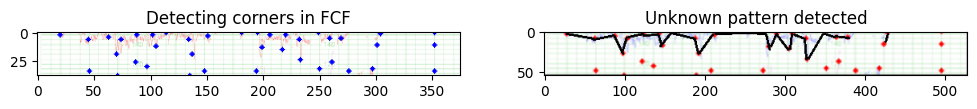

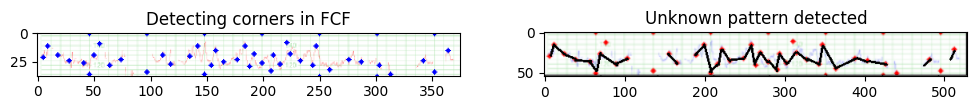

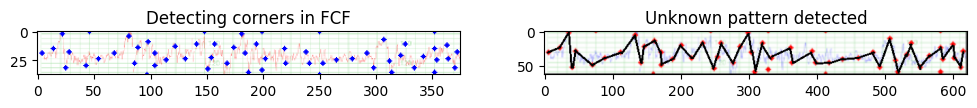

In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

train_images = [cv2.imread("extracted_images/page1.png"), cv2.imread("extracted_images/page19.png"), cv2.imread("extracted_images/page59.png")]
processed_images = []  # list to store processed images

for i, page in enumerate(train_images):
    x, y, width, height = 50, 200, page.shape[1], page.shape[0] - 200 
    page = page[y:y+height, x:x+width]  # crop the image to remove unwanted parts
    page = cv2.resize(page, (0, 0), fx=0.6, fy=0.6)  # resize to 0.6 the original size
    x, y, width, height = 0, 0, page.shape[1], page.shape[0] - 130 
    page = page[y:y+height, x:x+width]  # crop the image to remove unwanted parts

    # convert to grayscale
    page_gray = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY)

    # detect corners using cv2.goodFeaturesToTrack
    corners = cv2.goodFeaturesToTrack(page_gray, maxCorners=100, qualityLevel=0.01, minDistance=10)

    # convert corners to integers
    corners = np.int0(corners)

    # filter corners based on their quality (keep corners with high quality)
    filtered_corners = []
    for corner in corners:
        x, y = corner.ravel()
        if page_gray[y, x] > 150: # keep corners with high quality but not too much because we want detail in the pattern
            filtered_corners.append((x, y))

    # draw blue circles for filtered corners
    for corner in filtered_corners:
        x, y = corner
        cv2.circle(page, (x, y), 2, (255, 0, 0), -1)  # draw blue circles for detected corners

    x, y, width, height = 0, 32, page.shape[1]-100, page.shape[0] - 70 
    processed_image = page[y:y+height, x:x+width]  # crop the image to remove unwanted parts
    processed_images.append(processed_image)  # store processed image

# display the images with detected corners and the corresponding new patterns
for i, processed_image in enumerate(processed_images):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title("Detecting corners in FCF")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.imread(f"new_patterns/pattern{i+1}.png"))  # access patterns using i+1 for correct indexing
    plt.title("Unknown pattern detected")
    plt.show()

These new patterns are created by joining every corner and they are an aproximation as they take some maxima and minima, in real life the results will look a lot more **noisier** as this is a simple representation

Some points have been excluded because before we set a threshold to keep high quality features. While the threshold might be enough to capture most of the details in the FCF we have some unwanted noise.

## Apply pattern matching given some templates

- Load up all templates

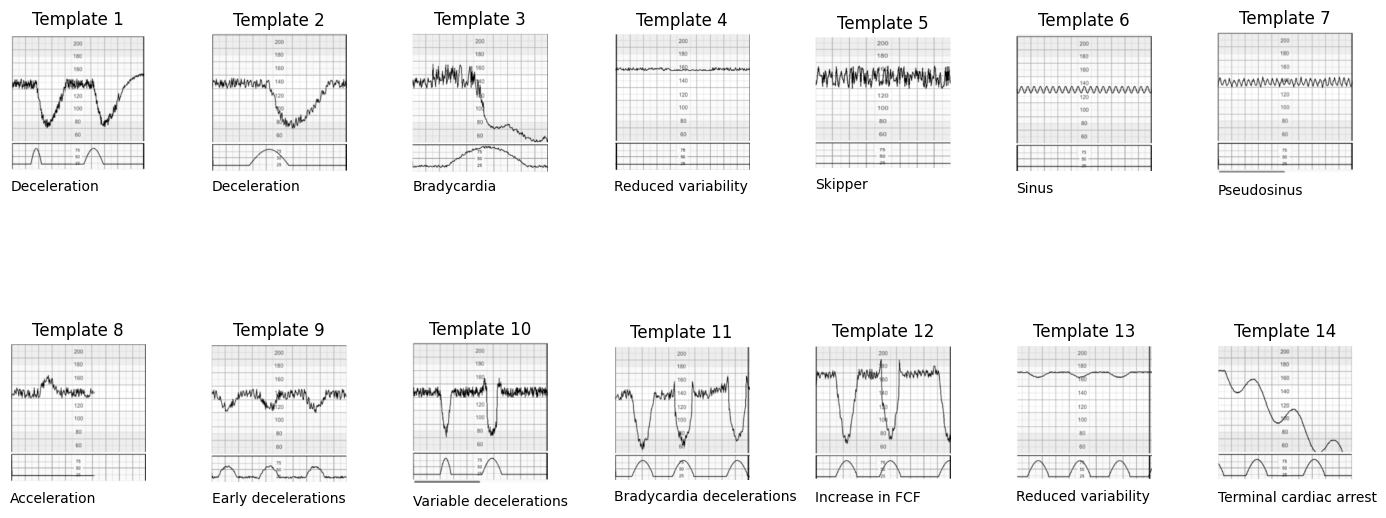

In [36]:
# load the templates in grayscale
template_1 = cv2.imread("templates/template_1_deceleration.png",0)

template_2 = cv2.imread("templates/template_2_deceleration.png", 0)

template_3 = cv2.imread("templates/template_3_bradycardia.png", 0)

template_4 = cv2.imread("templates/template_4_reduced_variability.png", 0)

template_5 = cv2.imread("templates/template_5_skipper.png", 0)

template_6 = cv2.imread("templates/template_6_sinus.png", 0)

template_7 = cv2.imread("templates/template_7_pseudosinus.png", 0)

template_8 = cv2.imread("templates/template_8_acceleration.png", 0)

template_9 = cv2.imread("templates/template_9_early_decelerations.png", 0)

template_10 = cv2.imread("templates/template_10_variable_decelerations.png", 0)

template_11 = cv2.imread("templates/template_11_bradycardia_decelerations.png", 0)

template_12 = cv2.imread("templates/template_12_increaseFCFb.png", 0)

template_13 = cv2.imread("templates/template_13_reduced_variability.png", 0)

template_14 = cv2.imread("templates/template_14_terminal_cardiac_arrest.png", 0)

templates = [template_1, template_2, template_3, template_4, template_5, template_6, template_7, template_8, template_9, template_10, template_11, template_12, template_13, template_14]
labels = ["Deceleration", "Deceleration", "Bradycardia", "Reduced variability", "Skipper", "Sinus", "Pseudosinus", "Acceleration", "Early decelerations", "Variable decelerations", "Bradycardia decelerations", "Increase in FCF", "Reduced variability", "Terminal cardiac arrest"]

plt.figure(figsize=(14, 7))

for i, template in enumerate(templates):
    plt.subplot(2, 7, i+1)
    plt.imshow(template, cmap="gray")
    plt.title(f"Template {i+1}")
    plt.axis("off")
    
    # adding text below each image
    plt.text(0, template.shape[0] + 30, labels[i], ha='left', fontsize=10)

plt.tight_layout()
plt.show()


> Reference: Guia de monitorización fetal intraparto basada en fisiopatologia

### Using SSIM to compare samples and templates and see similarities

*Here we change the color space to improve thresholding, because we're dealing with images that might not perform optimally in the RGB color space*

Sample 1 matches Template 8 with SSIM score: 0.7553
Sample 2 matches Template 8 with SSIM score: 0.7571
Sample 3 matches Template 8 with SSIM score: 0.7323
Sample 4 matches Template 6 with SSIM score: 0.7033
Sample 5 matches Template 14 with SSIM score: 0.7241
Sample 6 matches Template 8 with SSIM score: 0.7343
Sample 7 matches Template 6 with SSIM score: 0.7528
Sample 8 matches Template 8 with SSIM score: 0.7379


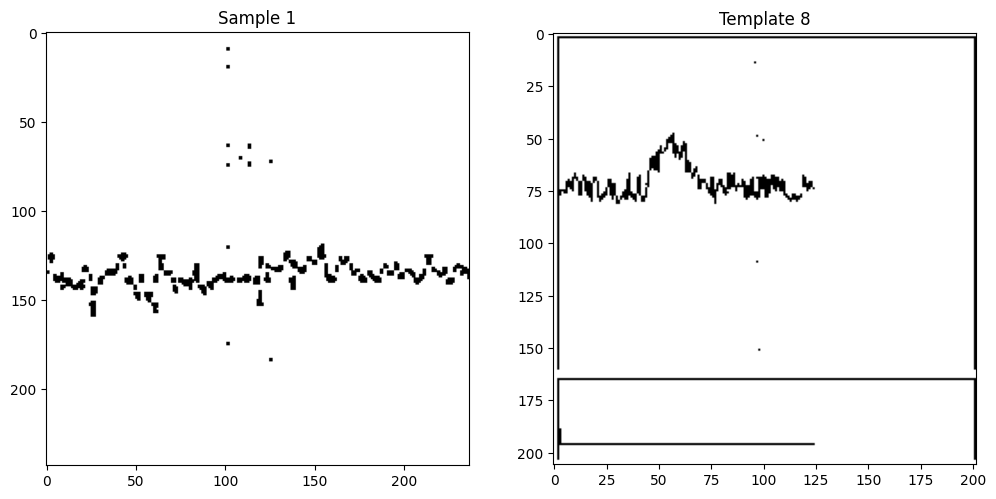

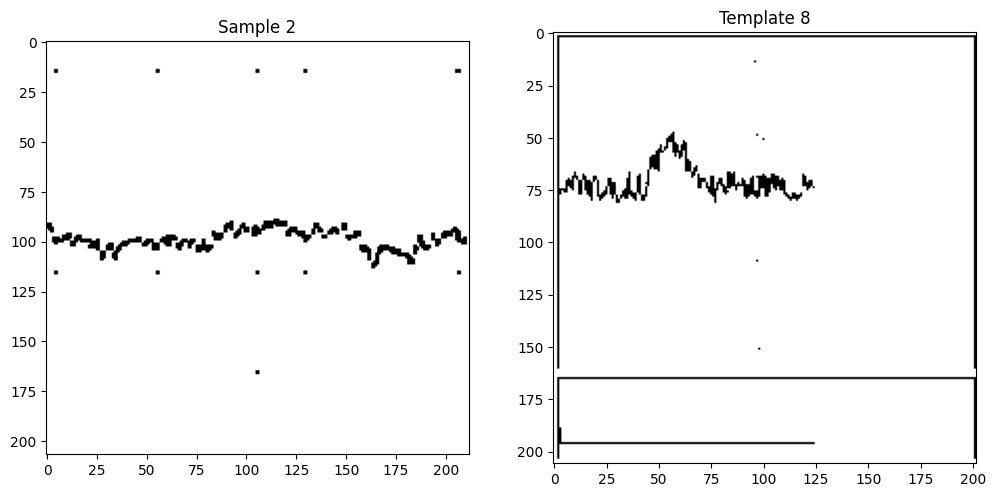

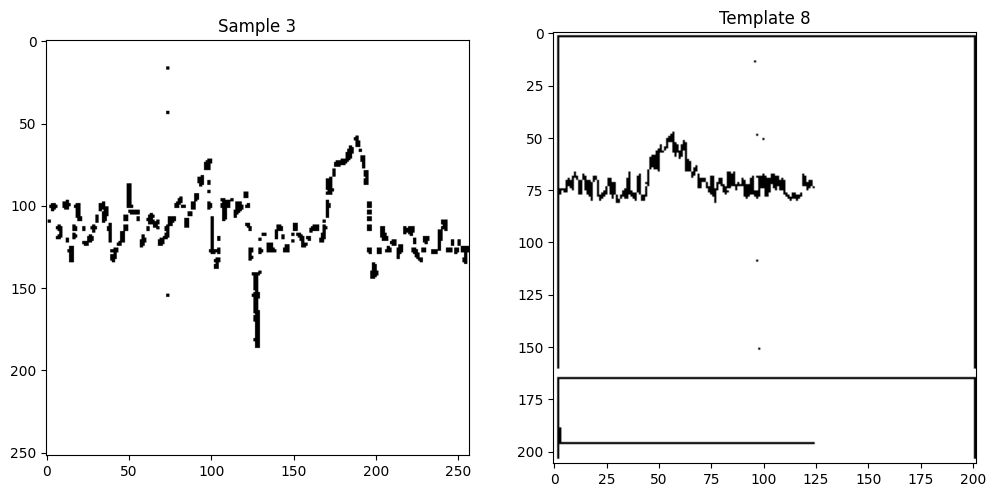

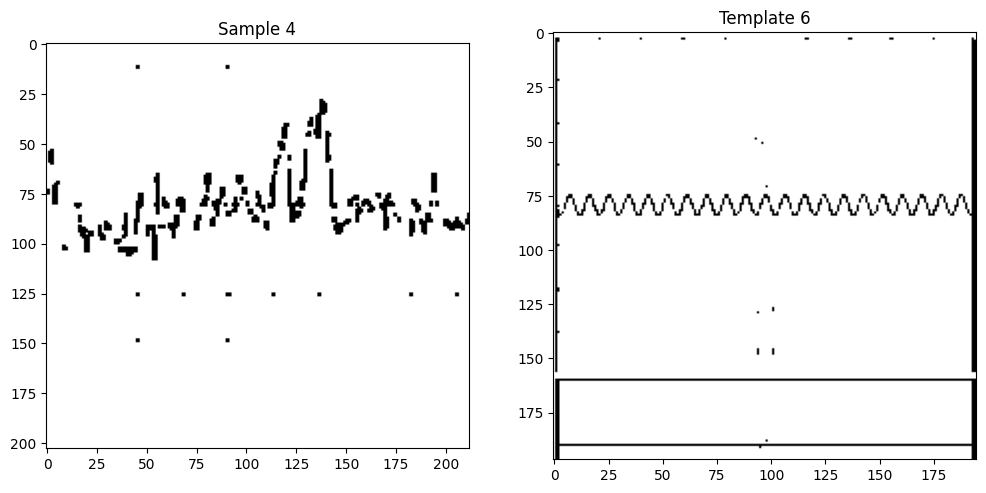

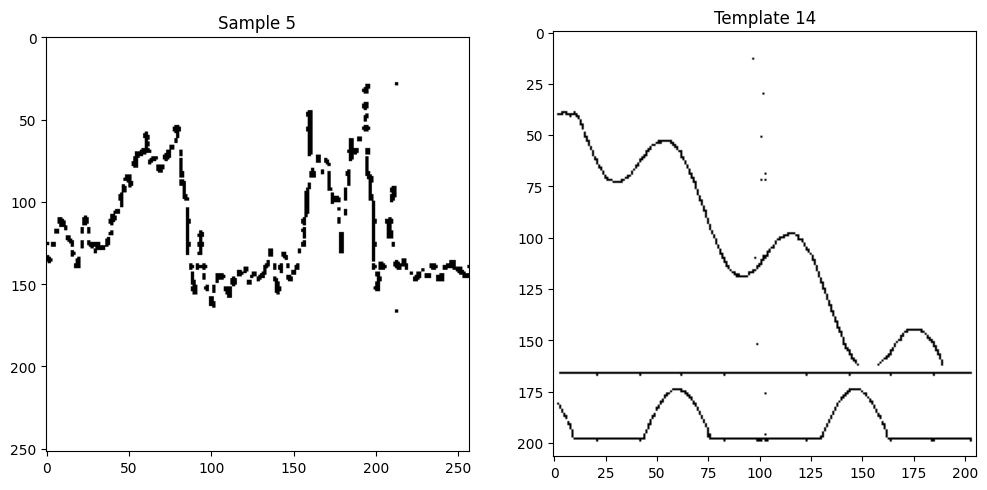

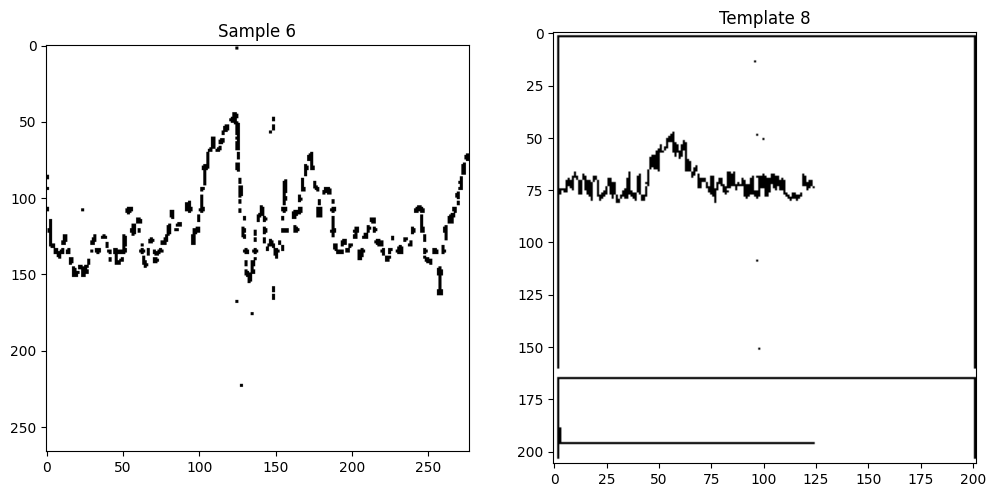

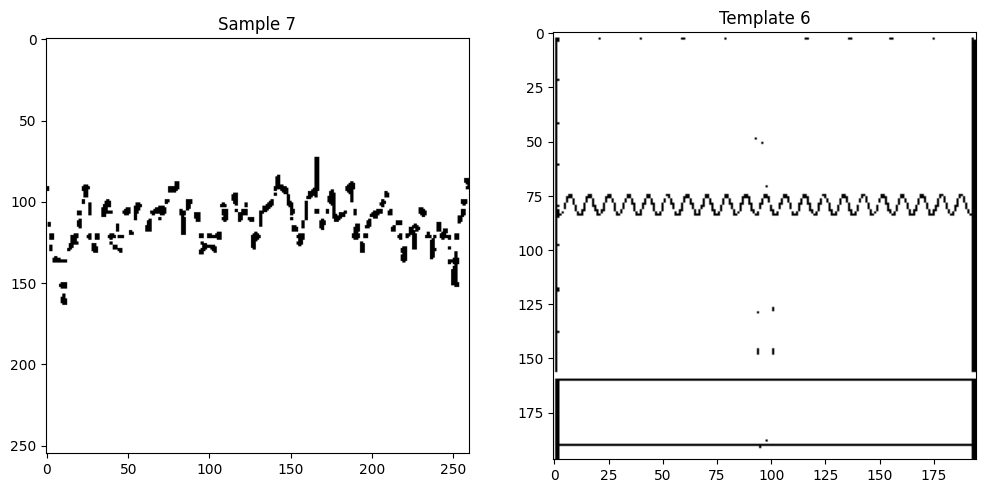

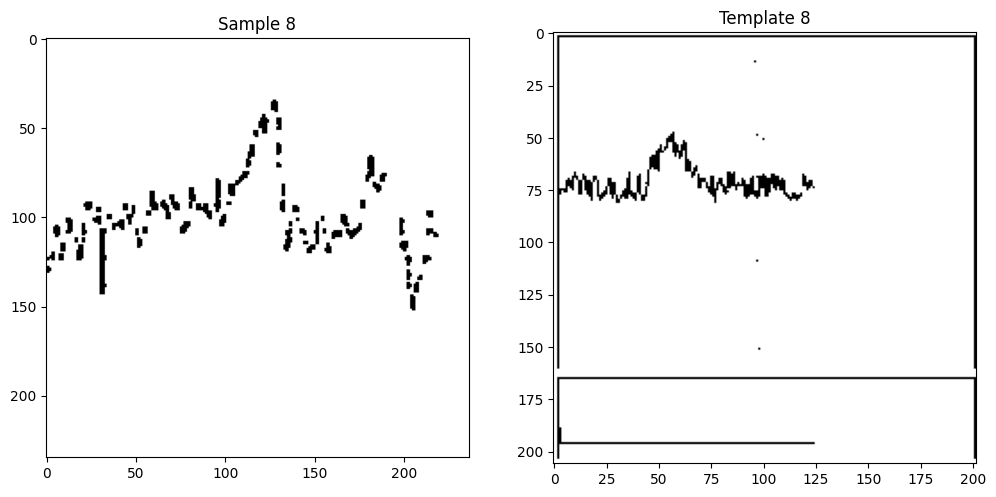

In [43]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from PyQt5.QtWidgets import QApplication, QMessageBox

alert = False # boolean to store alert status
# store the templates in a list
templates = [template_1, template_2, template_3, template_4, template_5, template_6, template_7, template_8, template_9, template_10, template_11, template_12, template_13, template_14]

# load the samples (in grayscale) in a list
samples = [cv2.imread(f"samples/s{i+1}.png") for i in range(8)]

# pass the samples to LAB color space to improve the accuracy of the thresholding
samples = [cv2.cvtColor(sample, cv2.COLOR_BGR2LAB) for sample in samples]

# create an adaptive thresholding mask using the L channel of the samples
for i, sample in enumerate(samples):
    l_channel, a_channel, b_channel = cv2.split(sample)
    l_adaptive_thresh = cv2.adaptiveThreshold(l_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv2.THRESH_BINARY, 19, 24)
    # dilate the image (erode because the background is white)
    kernel = np.ones((2, 2), np.uint8)
    l_adaptive_thresh = cv2.erode(l_adaptive_thresh, kernel, iterations=1)
    samples[i] = l_adaptive_thresh

# binary threshold the samples and templates
binary_samples = [cv2.threshold(sample, 0, 255, cv2.THRESH_BINARY)[1] for sample in samples]
binary_templates = [cv2.threshold(template, 127, 255, cv2.THRESH_BINARY)[1] for template in templates]

SSIM_scores = []  # list to store SSIM scores
max_SSIM_indices = []  # list to store indices of max SSIM scores

# compute SSIM between the samples and the templates
for sample_index, sample in enumerate(binary_samples):
    ssim_scores_for_sample = []
    for template_index, template in enumerate(binary_templates):
        # resize the template to match the sample's dimensions
        resized_template = cv2.resize(template, (sample.shape[1], sample.shape[0]))
        ssim_score, _ = ssim(sample, resized_template, full=True)
        ssim_scores_for_sample.append(ssim_score)
    SSIM_scores.append(ssim_scores_for_sample)
    max_SSIM_indices.append((sample_index, np.argmax(ssim_scores_for_sample)))

# convert SSIM scores to a numpy array
SSIM_scores = np.array(SSIM_scores)

# get the maximum SSIM score for each sample
max_SSIM_scores = np.max(SSIM_scores, axis=1)

# print the maximum SSIM scores and corresponding indices
for index, score in enumerate(max_SSIM_scores):
    sample_index, template_index = max_SSIM_indices[index]
    if score >= 0.7:
        alert = True
    print(f"Sample {sample_index + 1} matches Template {template_index + 1} with SSIM score: {score:.4f}")

# plot the samples and the corresponding templates
for sample_index, template_index in max_SSIM_indices:
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(binary_samples[sample_index], cmap="gray")
    plt.title(f"Sample {sample_index + 1}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(binary_templates[template_index], cmap="gray")
    plt.title(f"Template {template_index + 1}")
    plt.show()

def display_message():
    app = QApplication([])

    message = "Warning! The given sample/s might indicate a sign of fetal distress."

    msg_box = QMessageBox()
    msg_box.setWindowTitle("Message")
    msg_box.setText(message)
    msg_box.exec_()

if alert:
    display_message()


The images have been analyzed thoroughly to be in the same position in the y-axis.

### Using IoU to compare samples and templates and see similarities

C:\Users\musta\AppData\Local\Temp\ipykernel_9092\1323905756.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


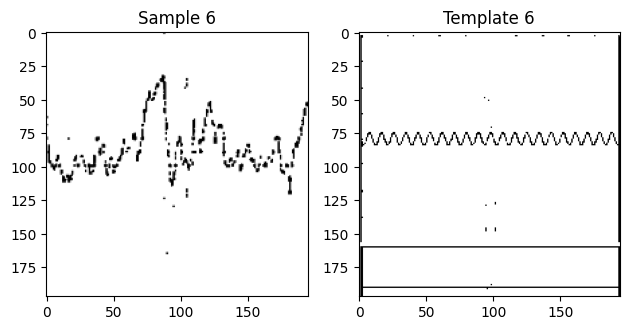

Sample index with maximum IoU: 6
Template index with maximum IoU: 6


In [13]:
import cv2
import numpy as np

# store the templates in a list
templates = [template_1, template_2, template_3, template_4, template_5, template_6, template_7, template_8, template_9, template_10, template_11, template_12, template_13, template_14]

# load the samples (in grayscale) in a list
samples = [cv2.imread(f"samples/s{i+1}.png") for i in range(6)]

# pass the samples to LAB color space to improve the accuracy of the thresholding
samples = [cv2.cvtColor(sample, cv2.COLOR_BGR2LAB) for sample in samples]

# create an adaptive thresholding mask using the L channel of the samples
for i, sample in enumerate(samples):
    l_channel, a_channel, b_channel = cv2.split(sample)
    l_adaptive_thresh = cv2.adaptiveThreshold(l_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv2.THRESH_BINARY, 19, 24)
    # Dilate the image
    kernel = np.ones((2, 2), np.uint8)
    l_adaptive_thresh = cv2.erode(l_adaptive_thresh, kernel, iterations=1)
    samples[i] = l_adaptive_thresh


plt.imshow(samples[0], cmap="gray")

# binary threshold the samples and templates
binary_samples = [cv2.threshold(sample, 0, 255, cv2.THRESH_BINARY)[1] for sample in samples]
binary_templates = [cv2.threshold(template, 127, 255, cv2.THRESH_BINARY)[1] for template in templates]

# resize samples to match template sizes while preserving aspect ratio
resized_samples = [cv2.resize(sample, (template.shape[1], template.shape[0])) for sample, template in zip(binary_samples, binary_templates)]

# function to calculate IoU
def calculate_iou(gt, pred):
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# calculate IoU scores for each pair of resized samples and templates
max_iou = -1
max_indices = (-1, -1)

for i, (sample, template) in enumerate(zip(resized_samples, binary_templates)):
    iou = calculate_iou(template, sample)
    if iou > max_iou:
        max_iou = iou
        max_indices = (i, i)

# get the indices of sample and template with the maximum IoU score
max_sample_index, max_template_index = max_indices

# plot the sample and template with the highest IoU score
plt.subplot(1, 2, 1)
plt.imshow(resized_samples[max_sample_index], cmap='gray')
plt.title(f'Sample {max_sample_index+1}')

plt.subplot(1, 2, 2)
plt.imshow(binary_templates[max_template_index], cmap='gray')
plt.title(f'Template {max_template_index+1}')

plt.tight_layout()
plt.show()

print(f"Sample index with maximum IoU: {max_sample_index+1}")
print(f"Template index with maximum IoU: {max_template_index+1}")


As we can see using IoU (Intersection Over Union) as a method for computing similarity is not suitable for this particular problem.

**Why?** Because it wrongly showcases a template that is really not that similar with respect to the sample.

Therefore, choosing SSIM as a similarity measure for establishing smart alerts it's better.